In [ ]:
# !python -m pip install more-itertools

In [ ]:
# !pip install pybktree

In [ ]:
# ! wget https://raw.githubusercontent.com/dwyl/english-words/master/words_dictionary.json

In [ ]:
# ! wget https://raw.githubusercontent.com/JorgeDuenasLerin/diccionario-espanol-txt/master/0_palabras_todas.txt

## Condiciones

- **Los nombres en minúscula, los tipos de datos (INT, VARCHAR, ETC) en mayúscula.** Quizás la primera letra puede ir en mayúscula, pero habria que agregar un procesamiento extra de "adelante de esa letra mientras sigan siendo minusculas pertenece al nombre del att".
- **El nombre del atributo no puede contener espacios en blanco y tampoco camelCase.** Por ahora es solo snake_case.
- **Las FK deben seguir el formato {nombre_tabla}_id o tener el mismo nombre que la PK de la tabla con la que se relacionan.** Las relaciones las sabemos con el módulo de Hough Transform.
- **Si es muchos a muchos, deberiamos chequear si tiene solo dos atributos y dos conexiones, o que tenga si o si el formato {tabla1}x{tabla2}.**

## TODO
- Falta generar las combinaciones para cuando el score del longest_sequence no es igual a 1. 
- Cuando hay una mayuscula en el medio que no puede haber en el nombre del atributo, se rompe. Mientras haya una minuscula o algo adelante debería ponerse bien. Lo que sí, eso daría a entender que es una letra que está mal asi que quizás conviene avisar.
- Hacerle un pequeño experimento de ver que pasa si agrandamos las cajas. Aunque no sé si se puede.
- El create_code tiene que ser después del for de clean_texts, asi puedo chequear que si existe {tabla}_id, es una FK. Si es muchos a muchos, deberiamos chequear si tiene solo dos atributos y dos conexiones..no? O que tenga si o si el formato {tabla1}x{tabla2}
- Como identificar múltiples PKs? que estén siempre al inicio? pero hasta cuál sería? O podemos hacer que tienen que tener _id en el nombre y no ser FKs

- **Evaluar OCR** https://towardsdatascience.com/evaluating-ocr-output-quality-with-character-error-rate-cer-and-word-error-rate-wer-853175297510

In [ ]:
# !pip install "paddleocr>=2.0.1"
# !python -m pip install paddlepaddle -i https://pypi.tuna.tsinghua.edu.cn/simple

In [1]:
import sys
sys.path.append("../")

from src.line_detection.hough import get_tablas

In [284]:
import re
import os
import cv2
import json
import jellyfish
import pybktree
import numpy as np
import itertools
from more_itertools import subslices

from paddleocr import PaddleOCR, draw_ocr
from PIL import Image
from IPython.display import display

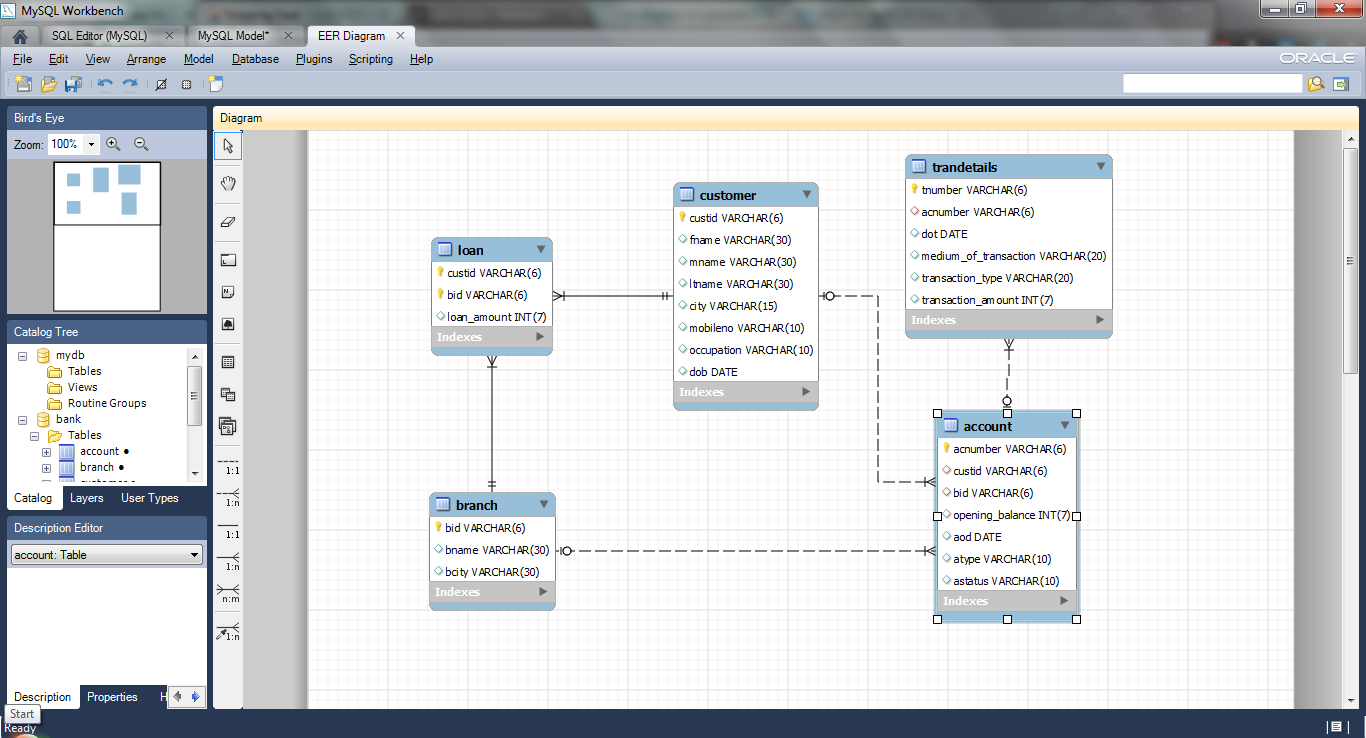

In [236]:
IMG_PATH = '/home/nacho/TFI-Cazcarra/data/imagenes_diagramas/ERDiagramsMySQL-1.png'
IMG_BASENAME = os.path.basename(IMG_PATH)
tablas, cardinalidades = get_tablas(IMG_BASENAME)
img = Image.open(IMG_PATH)
img

In [237]:
ocr = PaddleOCR(use_angle_cls=False, lang='en', show_log=False, 
                det_algorithm_dir="/home/nacho/TFI-Cazcarra/ocr/db/", 
                #rec_char_dict_path="../icr15_dict_original.txt",
                rec_algorithm_dir="/home/nacho/TFI-Cazcarra/ocr/svtr/", det_db_score_mode="slow")

In [238]:
with open("./words_dictionary.json", "rb") as f:
    english_dict = f.read()
english_words = json.loads(english_dict).keys()

with open("./0_palabras_todas.txt", "rb") as f:
    spanish_words = f.readlines()
spanish_words = [s.decode('utf8').replace("\n", "") for s in spanish_words]

In [239]:
class Item():
    def __init__(self, value):
        self.value = value

def item_distance(x, y):
    return jellyfish.levenshtein_distance(x.value, y.value)

english_tree = pybktree.BKTree(item_distance, [Item(w) for w in english_words])
spanish_tree = pybktree.BKTree(item_distance, [Item(w) for w in spanish_words])

In [240]:
def reescale(img, scale_percent=150):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC)
    return img

In [241]:
img = Image.open(IMG_PATH)
img = np.array(img)

images = []
results = []

for t in tablas:
    tabla_cropped = img[t[1]:t[3], t[0]:t[2]]
    tabla_cropped = reescale(tabla_cropped)
    result = ocr.ocr(tabla_cropped, cls=False)
    
    images.append(Image.fromarray(tabla_cropped))
    results.append(result[0])

In [242]:
def get_allowed_dtypes(db_name):
    if db_name.lower() == "mysql":
        STRING_TYPES = ["CHAR", "VARCHAR", "BINARY", "VARBINARY", "TINYBLOB", "TINYTEXT", "TEXT", "BLOB", 
                        "MEDIUMTEXT", "MEDIUMBLOB", "LONGTEXT", "LONGBLOB", "ENUM", "SET"]
        NUMERIC_TYPES = ["BIT", "TINYINT", "BOOLEAN", "SMALLINT", "MEDIUMINT", "INT", "INTEGER", "BIGINT", 
                         "FLOAT", "DOUBLE", "DOUBLE PRECISION", "DECIMAL", "DEC"]
        DATETIME_TYPES = ["DATE", "DATETIME", "TIMESTAMP", "TIME", "YEAR"]
        SPATIAL_TYPES = ["GEOMETRY", "POINT", "LINESTRING", "POLYGON"]
        return (STRING_TYPES + NUMERIC_TYPES + DATETIME_TYPES + SPATIAL_TYPES)
    else:
        print(f"'{db_name}' not supported yet!")
        return []

In [243]:
def get_dtype_number(text):
    if "," not in text:
        return re.findall("\d+", text) # Devuelve solo numeros juntos.
    else:
        return re.findall("\d+\,\d+", text) # Devuelve numeros con coma para dtypes como DECIMAL(5,2)

In [244]:
def sep_text(text):
    '''
    Separa las palabras pegadas a una mayúscula como city_idVARCHAR(45). O sea, cuando no se detecta el espacio.
    '''
    return re.findall("[A-Z]+[^A-Z]*|[^A-Z]+",text)

In [245]:
def get_dtype(possible_dtype, dtypes):
    '''
    Devuelve el dtype que más se le parece al string. Para hacerlo más rapido podría usar un bktree.
    '''
    dict_dtypes = {k: jellyfish.jaro_distance(possible_dtype, k) for k in dtypes}
    return (max(dict_dtypes, key=dict_dtypes.get), max(dict_dtypes.values()))

In [246]:
## Ejemplo "hola_c omo e st as"
## ["hola", "c omo e st as"]
## Para "c omo e st as" habría que generar todas las combinaciones


## Generas combinaciones desde 0 a len(str). Cuando encontras la palabra correcta para un subset, 
##    ahi recien las eliminas del string normal.
## o mejor aun, haces todas pero todas las combinaciones

## Agarras todas las combinaciones y le calculas el jaccard distance a todas dentro de cada subset.
## Si tienen la misma distancia, toma la combinación mas grande.

## En TODOS los casos donde se dude, se avisa


## EJEMPLOS A PENSAR:
# "pic ture" -> picture
# "table_nam e" -> table_name
# "pay ment_data" -> payment_data
# "pay ments_data" -> payments_data
# "pay men ls_data" -> payments_data
# "word_to fix" -> word_to_fix
# "n ame s" -> names
# "ias t" -> last

In [279]:
def chunks(items, cutpoints):
    return [items[i:j] for i,j in zip([0] + cutpoints, cutpoints + [len(items)])]

def generate_chunks(items, n):
    indices = range(1,len(items))
    return [chunks(items,list(cutpoints)) for cutpoints in itertools.combinations(indices,n-1)]

In [ ]:
slices_dict = get_slices_dict(tree, slices)

In [301]:
slices

[['n'],
 ['n', 'a'],
 ['n', 'a', 'me'],
 ['n', 'a', 'me', 's'],
 ['a'],
 ['a', 'me'],
 ['a', 'me', 's'],
 ['me'],
 ['me', 's'],
 ['s']]

In [300]:
slices_dict

{'n': {'n': 1.0, 'nb': 0.83, 'nd': 0.83, 'ne': 0.83, 'ng': 0.83},
 'na': {'na': 1.0, 'naa': 0.89, 'naf': 0.89, 'nae': 0.89, 'nab': 0.89},
 'name': {'name': 1.0,
  'fname': 0.93,
  'named': 0.93,
  'nambe': 0.93,
  'names': 0.93},
 'names': {'names': 1.0,
  'dames': 0.87,
  'cames': 0.87,
  'namers': 0.94,
  'name': 0.93},
 'a': {'a': 1.0, 'aa': 0.83, 'ab': 0.83, 'ac': 0.83, 'ad': 0.83},
 'ame': {'ame': 1.0, 'dame': 0.92, 'acme': 0.92, 'came': 0.92, 'game': 0.92},
 'ames': {'dames': 0.93,
  'acmes': 0.93,
  'cames': 0.93,
  'fames': 0.93,
  'games': 0.93},
 'me': {'me': 1.0, 'mel': 0.89, 'meg': 0.89, 'mes': 0.89, 'med': 0.89},
 'mes': {'mes': 1.0, 'mels': 0.92, 'mesh': 0.92, 'mesa': 0.92, 'mems': 0.92},
 's': {'s': 1.0, 'sb': 0.83, 'sk': 0.83, 'sc': 0.83, 'sf': 0.83}}

In [337]:
# Falta mejorar un poquito pero va por acá.
all_combs.sort()
[l for l in list(k for k,_ in itertools.groupby(all_combs))]

[['p', 'i', 'c', 't', 'u', 'r', 'e', 's'],
 ['p', 'i', 'c', 't', 'u', 'r', 'es'],
 ['p', 'i', 'c', 't', 'u', 're', 's'],
 ['p', 'i', 'c', 't', 'u', 'res'],
 ['p', 'i', 'c', 't', 'ur', 'e', 's'],
 ['p', 'i', 'c', 't', 'ur', 'es'],
 ['p', 'i', 'c', 't', 'ure', 's'],
 ['p', 'i', 'c', 't', 'ures'],
 ['p', 'i', 'c', 'tu', 'r', 'e', 's'],
 ['p', 'i', 'c', 'tu', 'r', 'es'],
 ['p', 'i', 'c', 'tu', 're', 's'],
 ['p', 'i', 'c', 'tu', 'res'],
 ['p', 'i', 'c', 'tur', 'e', 's'],
 ['p', 'i', 'c', 'tur', 'es'],
 ['p', 'i', 'c', 'ture', 's'],
 ['p', 'i', 'c', 'tures'],
 ['p', 'i', 'ct', 'u', 'r', 'e', 's'],
 ['p', 'i', 'ct', 'u', 'r', 'es'],
 ['p', 'i', 'ct', 'u', 're', 's'],
 ['p', 'i', 'ct', 'u', 'res'],
 ['p', 'i', 'ct', 'ur', 'e', 's'],
 ['p', 'i', 'ct', 'ur', 'es'],
 ['p', 'i', 'ct', 'ure', 's'],
 ['p', 'i', 'ct', 'ures'],
 ['p', 'i', 'ctu', 'r', 'e', 's'],
 ['p', 'i', 'ctu', 'r', 'es'],
 ['p', 'i', 'ctu', 're', 's'],
 ['p', 'i', 'ctu', 'res'],
 ['p', 'i', 'ctur', 'e', 's'],
 ['p', 'i', 'ctur', '

In [248]:
def get_dist_map(key, neighbors, top_n=5):
    dist_map = {n[1]: round(jellyfish.jaro_distance(key, n[1]), 2) for n in neighbors}
    sorted_topn = sorted(dist_map, key=dist_map.get, reverse=True)[:top_n]
    return {k:v for k,v in dist_map.items() if k in sorted_topn}


def top_n_dist_map(tree, slice_key, tolerance, top_n):
    slice_value = tree.find(Item(slice_key), tolerance)
    if slice_value:
        slice_value = [(res[0], res[1].value) for res in slice_value]
    return get_dist_map(key=slice_key, neighbors=slice_value, top_n=top_n)


def get_slices_dict(tree, slices, tolerance=1, top_n=5):
    slices_dict = {}
    for slice_ in slices:
        slice_key = "".join(slice_)
        slice_value = top_n_dist_map(tree, slice_key, tolerance, top_n)
        slices_dict[slice_key] = slice_value
    return slices_dict


def get_tree(mode):
    if mode == "english":
        tree = english_tree
    else:
        tree = spanish_tree
    return tree
        
        
def sanitize_words(splitted_attribute, mode="english"):
    '''
    Sanitizes every word of the attribute.
    '''
    tree = get_tree(mode)
    TOLERANCE = 1
    
    sanitized = []
    for word in splitted_attribute:
        word = word.strip()
        if " " in word:
            word_to_fix = word.split(" ")
            slices = list(subslices(word_to_fix))
            slices_dict = get_slices_dict(tree, slices)
            longest_key = max(slices_dict.keys(), key=len) # Agarramos la secuencia más larga.
            longest_key_dict = slices_dict[longest_key] # Top N para esa secuencia.
            # Hay que dar por hecho que no hay typos, solo problemas con los espacios.
            if longest_key_dict and max(longest_key_dict.values()) == 1:
                longest_key_max_score = max(longest_key_dict, key=longest_key_dict.get)
                print(longest_key_max_score)
                fixed_word = longest_key_max_score
            else:
                # Me tengo la secuencia en partes cuya suma de scores sea la mayor.
                fixed_word = ""
            sanitized.append(fixed_word)
        else:
            sanitized.append(word) # Dejar así nomás; no suele haber typos y la podes cagar facilmente.
    return "_".join(sanitized)

In [250]:
# El problema es si se confunde una L por una | o cosas así. Status: deprecated.
def clean_attribute(attribute):
    '''
    Removes from str everything that's not a digit, underscore, dollar signs & characters (upper or lower).
    '''
    return re.sub("[^0-9a-zA-Z$_]+", "", attribute)


def get_clean_attribute(attribute):
    '''
    Debería ser algo así:
    - Separa por underscore porque espacios no deberia haber.
    - Lo que haya quedado junto y tenga espacios en blanco, lo probamos con y sin y nos quedamos con la palabra de
    ambas divisiones que tenga menor tolerancia.
    - Si hay que juntar juntamos, y si no separamos.
    - Reemplazamos los espacios por underscore y devolvemos.
    '''
    attribute = attribute.strip()
    if " " in attribute:
        splitted_attribute = attribute.split("_")
        attribute = sanitize_words(splitted_attribute)
#     else: # No vale la pena... deberia estar limpio.
#         attribute = clean_attribute(attribute)
    
    return attribute.replace("|","l").replace("I","l")

In [251]:
def delim_attribute(text_list):   
    flag = False
    attribute = ""
    i = -1
    while not flag:
        i += 1
        if not text_list[i].isalpha() and not attribute:
            continue
        
        if text_list[i].isupper() and not attribute:
            attribute += text_list[i]
        elif text_list[i].islower() or text_list[i].isspace() or text_list[i].isdigit() or text_list[i] in ["_","$"]:
            attribute += text_list[i]
        else:
            flag = True
    attribute = clean_attribute(attribute)
    dtype = "".join(text_list[i:])
            
    return attribute, dtype

In [252]:
def separate(text, db_name="mysql"):
    text_list = sep_text(text)
    text_list = " ".join(text_list)
    attribute, dtype = delim_attribute(text_list)
    attribute = get_clean_attribute(attribute)
    dtype_number = get_dtype_number(dtype)
    dtype = dtype.replace("(", "").replace(")","")
    dtype, _ = get_dtype(dtype, dtypes=get_allowed_dtypes(db_name))
    if dtype_number:
        dtype += f"({dtype_number[0]})"
        
    return attribute, dtype

In [253]:
def clean_texts(texts):
    if "Indexes" in texts:
        # Todo lo que venga después de Indexes está mal o pertenece a otra cosa.
        indexes_idx = texts.index("Indexes")
        texts = texts[:indexes_idx]
        
    table_name = texts[0]
    
    attributes = {} # K=name, V=type
    for t in texts[1:]:
        attribute, dtype = separate(t, db_name="mysql")
        attributes[attribute.strip()] = dtype
            
    return table_name, attributes





['loan', '3 custid VARCHAR(6)', '? bid VARCHAR 6)', 'loan_am ount INT (7)', 'Indexes']
loan {'custid': 'VARCHAR(6)', 'bid': 'VARCHAR(6)', 'loan_amount': 'INT(7)'}


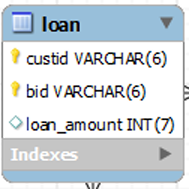





['branch', '7 bid V ARCHAR(6)', 'bname VARCH AR (30)', 'bcity V ARCHAR(30', 'Indexes']
branch {'bid': 'VARCHAR(6)', 'bname': 'VARCHAR(30)', 'bcity': 'VARCHAR(30)'}


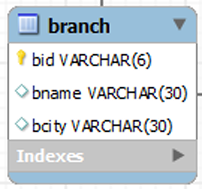





['m customer', '3 custid VARCHAR(6)', '> fnam e VARCHAR(30)', 'mname VARCHAR (30)', 'Itname VARCH AR (30)', 'V city V ARCHAR(15)', 'mobileno VARCH AR (10)', 'occupation VARCH AR(10)', 'dob DATE', 'Indexes']
m customer {'custid': 'VARCHAR(6)', 'fname': 'VARCHAR(30)', 'mname': 'VARCHAR(30)', 'ltname': 'VARCHAR(30)', 'Vcity': 'VARCHAR(15)', 'mobileno': 'VARCHAR(10)', 'occupation': 'VARCHAR(10)', 'dob': 'DATE'}


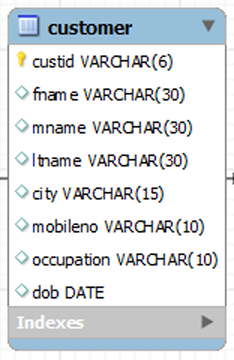





['trandetails', '? tnumber VARCH AR(6)', 'acnumber VARCH AR 6)', 'V dot D ATE', 'medium_of_transaction VARCH AR (20)', 'transaction_type V ARCHAR (20)', 'transaction_am ount INT(7)', 'Indexes']
trandetails {'tnumber': 'VARCHAR(6)', 'acnumber': 'VARCHAR(6)', 'Vdot': 'DATE', 'medium_of_transaction': 'VARCHAR(20)', 'transaction_type': 'VARCHAR(20)', 'transaction_amount': 'INT(7)'}


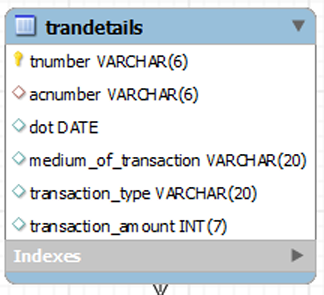





['account', '? acnumber VARCH AR 6)', 'custid VARCH AR(6)', '>bid VARCHAR 6)', 'opening_balance INT(7', 'V aod D ATE', 'V atype V ARCHAR(10', 'V astatus V ARCHAR(10)', 'Indexes']
account {'acnumber': 'VARCHAR(6)', 'custid': 'VARCHAR(6)', 'bid': 'VARCHAR(6)', 'opening_balance': 'INT(7)', 'Vaod': 'DATE', 'Vatype': 'VARCHAR(10)', 'Vastatus': 'VARCHAR(10)'}


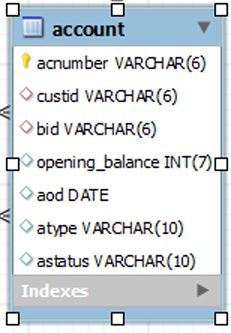

In [254]:
for i, r in zip(images, results):
    boxes = [line[0] for line in r]
    txts = [line[1][0].strip() for line in r]
    scores = [line[1][1] for line in r]
    print("\n\n\n")
    print(txts)
    table, dict_attributes = clean_texts(txts)
    
    print(table, dict_attributes)
    display(i)

In [ ]:
def create_code(table, dict_attributes):
    '''
    Crea una tabla de MySQL
    '''
    attributes_code = "  "
    
    i = 0
    for k, v in dict_attributes.items():
        attributes_code += k + " " + v
        if i == 0:
            attributes_code += " PRIMARY KEY"
            
        if i != len(dict_attributes)-1:
            attributes_code += ",\n   "
        else:
            attributes_code += "   "
            
        i += 1
    
    llave_abre = "{"
    llave_cierra = "}"
    code = f" CREATE TABLE {table} ( \n {attributes_code} \n )"
    return code

In [ ]:
# El create_code tiene que ser después del for de clean_texts, 
# asi puedo chequear que si existe {tabla}_id, es una FK.

# for i, r in zip(images, results):
#     txts = [line[1][0].strip() for line in r]
#     table, dict_attributes = clean_texts(txts)
#     print(create_code(table, dict_attributes))
#     print("\n\n")